#### Notebook for Exploring Pruning of BERT: Inspired from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=YOCrQwPoIrJG

#### Task selected using Huggingface's Datasets

In [226]:
import torch
import torch.nn.utils.prune as prune
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt

##### Task
CoLA outputs a binary label of gramatically correct or not. It was deemed the easiest place to start. 

In [4]:
# Setup chosen task and metric
task = "cola"
checkpoint = "bert-base-uncased"
batch_size = 16

dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task)

/tmp/ipykernel_12341/887701111.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("glue", task)
/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [5]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.", 'label': 1, 'idx': 0}


In [6]:
print(metric)

# Using metric
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

{'matthews_correlation': 0.0640210337986158}

In [7]:
# Define tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
# Example
print(tokenizer("Hello, this one sentence!", "And this sentence goes with it."))

#print(f"Sentence: {dataset['train'][0]['sentence']}")

# preprocess function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True)

preprocess_function(dataset['train'][:5])
encoded_dataset = dataset.map(preprocess_function, batched=True)

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [82]:
# Grab BERT for sequence classification

num_labels = 2
model = transformers.BertForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
metric_name = "matthews_correlation"
model_name = checkpoint.split("/")[-1]

args = transformers.TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [84]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [85]:
validation_key = "validation"
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [86]:
trainer.train()

  0%|          | 0/2675 [00:00<?, ?it/s]

 19%|█▉        | 503/2675 [00:23<01:40, 21.69it/s]

{'loss': 0.4892, 'grad_norm': 8.492907524108887, 'learning_rate': 1.6261682242990654e-05, 'epoch': 0.93}


 20%|██        | 535/2675 [00:25<01:27, 24.52it/s]

{'eval_loss': 0.44444724917411804, 'eval_matthews_correlation': 0.5272175286888164, 'eval_runtime': 0.6017, 'eval_samples_per_second': 1733.381, 'eval_steps_per_second': 109.687, 'epoch': 1.0}


 38%|███▊      | 1004/2675 [00:49<01:14, 22.56it/s]

{'loss': 0.2934, 'grad_norm': 7.86383581161499, 'learning_rate': 1.2523364485981309e-05, 'epoch': 1.87}


 40%|████      | 1070/2675 [00:53<01:12, 22.08it/s]

{'eval_loss': 0.47043007612228394, 'eval_matthews_correlation': 0.5932805322494611, 'eval_runtime': 0.6902, 'eval_samples_per_second': 1511.161, 'eval_steps_per_second': 95.625, 'epoch': 2.0}


 56%|█████▌    | 1502/2675 [01:14<00:54, 21.38it/s]

{'loss': 0.1912, 'grad_norm': 0.32137614488601685, 'learning_rate': 8.785046728971963e-06, 'epoch': 2.8}


 60%|██████    | 1605/2675 [01:19<00:40, 26.19it/s]

{'eval_loss': 0.6296312808990479, 'eval_matthews_correlation': 0.5680628967969402, 'eval_runtime': 0.5923, 'eval_samples_per_second': 1760.785, 'eval_steps_per_second': 111.421, 'epoch': 3.0}


 75%|███████▍  | 2003/2675 [01:40<00:26, 25.22it/s]

{'loss': 0.138, 'grad_norm': 0.15411821007728577, 'learning_rate': 5.046728971962617e-06, 'epoch': 3.74}


 80%|████████  | 2140/2675 [01:47<00:25, 20.78it/s]

{'eval_loss': 0.9082818627357483, 'eval_matthews_correlation': 0.5572696682585848, 'eval_runtime': 0.5918, 'eval_samples_per_second': 1762.401, 'eval_steps_per_second': 111.523, 'epoch': 4.0}


 94%|█████████▎| 2502/2675 [02:06<00:07, 21.71it/s]

{'loss': 0.0874, 'grad_norm': 0.07196631282567978, 'learning_rate': 1.308411214953271e-06, 'epoch': 4.67}


100%|██████████| 2675/2675 [02:14<00:00, 23.54it/s]

{'eval_loss': 0.9003195762634277, 'eval_matthews_correlation': 0.5857509882742485, 'eval_runtime': 0.577, 'eval_samples_per_second': 1807.756, 'eval_steps_per_second': 114.393, 'epoch': 5.0}


100%|██████████| 2675/2675 [02:17<00:00, 19.43it/s]

{'train_runtime': 137.6442, 'train_samples_per_second': 310.62, 'train_steps_per_second': 19.434, 'train_loss': 0.22967105580267505, 'epoch': 5.0}


TrainOutput(global_step=2675, training_loss=0.22967105580267505, metrics={'train_runtime': 137.6442, 'train_samples_per_second': 310.62, 'train_steps_per_second': 19.434, 'total_flos': 454848611954580.0, 'train_loss': 0.22967105580267505, 'epoch': 5.0})

In [158]:
ret = trainer.evaluate()
print(ret)
print(ret['eval_matthews_correlation'])

100%|██████████| 66/66 [00:00<00:00, 112.87it/s]

{'eval_loss': 0.47043007612228394, 'eval_matthews_correlation': 0.5932805322494611, 'eval_runtime': 0.6186, 'eval_samples_per_second': 1686.186, 'eval_steps_per_second': 106.7, 'epoch': 5.0}
0.5932805322494611


In [ ]:
print(trainer.eval_matthews_correlation)

In [88]:
# Save model
trainer.save_model("bert_pruning_model")

In [79]:
#model == trained_model

#for p1, p2 in zip(model.parameters(), trained_model.parameters()):
#    if(p1.data.ne(p2.data).sum() > 0):
#        print('False')
#print('True')

True

In [209]:
# Load model
trained_model = transformers.BertForSequenceClassification.from_pretrained('bert_pruning_model', num_labels=num_labels)

In [221]:
# Calculate sparisty of the network
def calcSparsity(model):
    zeros = 0
    elements = 0

    for name, param in model.named_parameters():

        # Layer was pruned if orig exists
        #parsed_name = name.split('_orig')
        # Layer was pruned
        #if(len(parsed_name) == 2 and parsed_name[0] in parameter_names):

        zero_count = torch.sum(param==0.0).item()
        zeros += zero_count

        element_count = param.numel()
        elements += element_count

    if(elements == 0):
        return 0

    return zeros / elements

In [211]:
# Select the parameters that you wish to prune
parameters_to_prune = []
parameter_names = []
for name, module in trained_model.named_modules():

    # Self-Attention
    #if isinstance(module, transformers.models.bert.modeling_bert.BertSelfAttention):
    #    parameters_to_prune.extend([
    #            (module.query, 'weight'),
    #            (module.key, 'weight'),
    #            (module.value, 'weight'),
    #        ])
    #print(name)
    #parameter_names.append(name)
    #parameter_names.extend([name + '.query', name + '.key', name + '.value'])

    # Linear: Includes linear layers in attention head as well
    if isinstance(module, torch.nn.Linear):
        parameters_to_prune.append((module, 'weight'))
        parameter_names.append(name + '.weight')

In [212]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9
)

for module,name in parameters_to_prune:
    prune.remove(module, name)

In [213]:
calcSparsity()

0.7030577077820607

##### Pruning Performance Using Matthews Correlation

In [222]:
metric_name = "matthews_correlation"
metric = datasets.load_metric("glue", task)

models = []

# Note: The pruning strength is for the subset of the neurons that you want to prune (defined by the paramater list created in the build parameter list function #
def buildParameterList(model):
    parameters_to_prune = []
    for name, module in model.named_modules():
        # Linear: Includes linear layers in attention head as well
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    return parameters_to_prune

# NOTE: Metric is defined globally
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # TODO: switch to torch?
    return metric.compute(predictions=predictions, references=labels)

def buildTrainer(model, encoded_dataset, tokenizer):

    args = transformers.TrainingArguments(
        f"{model_name}-finetuned-{task}-Testing",
        per_device_eval_batch_size=batch_size,
        metric_for_best_model=metric_name,
        push_to_hub=False,
    )

    evaluator = transformers.Trainer(
        model,
        args,
        eval_dataset=encoded_dataset['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    return evaluator

def evaluateUnstructuredPruningOnBert(model_directory, dataset, tokenizer, pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], num_labels=2):

    pruning_results = []

    # Try different pruning methods
    for p_strength in pruning_strength:

        # Load model
        test_model = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels)

        # Choose layers to prune
        pruning_params = buildParameterList(test_model)

        if(p_strength > 0):

            # Perform pruning
            prune.global_unstructured(
                pruning_params,
                pruning_method=prune.L1Unstructured,
                amount=p_strength
            )

            # Make pruning permenant
            for module,name in pruning_params:
                prune.remove(module, name)

        sparsity = calcSparsity(test_model)
        print(f"Pruning strength: {p_strength}, Sparsity: {sparsity}")

        # Create evaluator
        evaluator = buildTrainer(test_model, dataset, tokenizer)

        # Evaluate performance on BERT 
        results = evaluator.evaluate()
        metric_res = results['eval_matthews_correlation']

        pruning_results.append((sparsity, metric_res))
        
    return pruning_results

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [223]:
model_directory = 'bert_pruning_model'
p_res = evaluateUnstructuredPruningOnBert(model_directory, encoded_dataset, tokenizer)

Pruning strength: 0, Sparsity: 0.0


100%|██████████| 66/66 [00:00<00:00, 115.14it/s]


Pruning strength: 0.1, Sparsity: 0.0781175271463504


100%|██████████| 66/66 [00:00<00:00, 114.81it/s]


Pruning strength: 0.2, Sparsity: 0.15623504515892755


100%|██████████| 66/66 [00:00<00:00, 117.86it/s]


Pruning strength: 0.3, Sparsity: 0.23435257230527795


100%|██████████| 66/66 [00:00<00:00, 111.59it/s]


Pruning strength: 0.4, Sparsity: 0.3124700903178551


100%|██████████| 66/66 [00:00<00:00, 114.70it/s]


Pruning strength: 0.5, Sparsity: 0.3905876174642055


100%|██████████| 66/66 [00:00<00:00, 114.06it/s]


Pruning strength: 0.6, Sparsity: 0.4687051446105559


100%|██████████| 66/66 [00:00<00:00, 107.86it/s]


Pruning strength: 0.7, Sparsity: 0.5468226626231331


100%|██████████| 66/66 [00:00<00:00, 112.45it/s]


Pruning strength: 0.8, Sparsity: 0.6249401897694835


100%|██████████| 66/66 [00:00<00:00, 108.91it/s]


Pruning strength: 0.9, Sparsity: 0.7030577077820607


100%|██████████| 66/66 [00:00<00:00, 109.81it/s]


In [224]:
print(p_res)

[(0, 0.5932805322494611), (0.1, 0.5779181076197502), (0.2, 0.559827888599451), (0.3, 0.5337975510473064), (0.4, 0.5179391870486293), (0.5, 0.37130794726495275), (0.6, 0.07583845140032916), (0.7, 0.018148342420931135), (0.8, 0.004186223773740697), (0.9, -0.03534585767137743)]


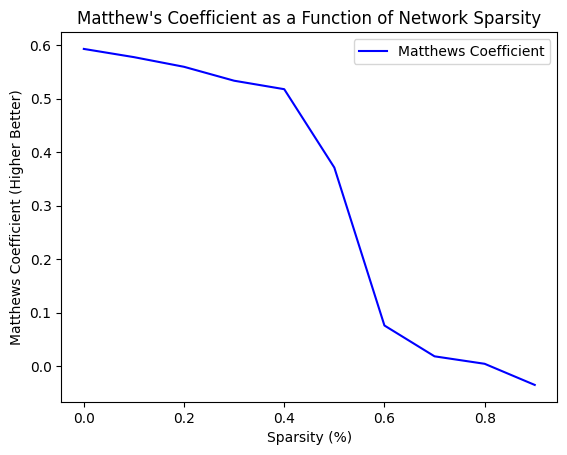

In [227]:
# Plot results
sparsities = []
metric_results = []

for sparsity, met in p_res:
    sparsities.append(sparsity)
    metric_results.append(met)

#plt.plot(sparsities, tr_acc_cpu, label="Training Accuracy", color="blue")
plt.plot(sparsities, metric_results, label="Matthews Coefficient", color="blue")
plt.title("Matthew's Coefficient as a Function of Network Sparsity")
plt.xlabel("Sparsity (%)")
plt.ylabel("Matthews Coefficient (Higher Better)")
plt.legend()
plt.show();